In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential, metrics, optimizers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D,\
                                    MaxPooling2D, UpSampling2D, GlobalAveragePooling2D,\
                                    Layer, Lambda, Flatten, Reshape, Conv2DTranspose,\
                                    Activation, LeakyReLU, Dropout, InputLayer, ReLU
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
pm = VGG19(include_top=False, weights='imagenet')

outputs = [pm.get_layer(l).output for l in ['block2_conv1', 'block3_conv1']]
classifier = Model(pm.input, outputs)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
feature_list = []
for img in tqdm(x_test) :
    inp = np.expand_dims(img, 0)
    inp = np.expand_dims(inp, 3)
    inp = np.concatenate([inp]*3, axis=-1)
    feature_list.append(classifier(inp))

100%|██████████| 10000/10000 [00:24<00:00, 406.08it/s]


In [5]:
def cosine_dist(x, y):
    N, H, W, C = x.shape
    
    x_vec = tf.transpose(x, perm=[0,3,1,2])
    y_vec = tf.transpose(y, perm=[0,3,1,2])
    
    y_mu = K.mean(y_vec, axis=[0, 2, 3], keepdims=True)
    
    x_centered = x_vec - y_mu
    y_centered = y_vec - y_mu
    
    x_normalized = x_centered / tf.norm(x_centered, ord=2, axis=1, keepdims=True)
    y_normalized = y_centered / tf.norm(y_centered, ord=2, axis=1, keepdims=True)

    ############
    x_normalized = tf.reshape(x_normalized, [N, C, -1])                                # (N, C, H*W)
    y_normalized = tf.reshape(y_normalized, [N, C, -1])                                # (N, C, H*W)
    
    ### TODO ### einsum 으로 bmm 대체 가능, 3D의 경우 matmul로 가능 -> Debug 필요
#     cosine_sim = torch.bmm(x_normalized.transpose(1, 2), y_normalized)

    x_normalized = tf.transpose(x_normalized, perm=[0,2,1])
    
    cosine_sim = tf.matmul(x_normalized, y_normalized)
    
    ############
    d = 1 - cosine_sim 
    
    return d
def contextual_loss(x1, y1, h=0.1):
    cx_loss = 0
    for x, y in zip(x1, y1):
        d = cosine_dist(x, y)
            
        d_min = K.min(d, axis=2, keepdims=True)        # (N, H*W, 1)
        # Eq (2)
        d_tilde = d / (d_min + 1e-5)
        # Eq(3)
        w = K.exp((1 - d_tilde) / h)
        # Eq(4)
        cx_ij = w / K.sum(w, axis=2, keepdims=True)       # (N, H*W, H*W)
        # Eq (1)
        cx = K.mean(K.max(cx_ij, axis=1), axis=1)  # (N, )
        cx_loss += K.mean(-K.log(cx))   
        
    return cx_loss

In [6]:
contextual_loss(feature_list[0], feature_list[1])

<tf.Tensor: shape=(), dtype=float32, numpy=1.2798009>

In [7]:
from math import sqrt

# calculate the Euclidean distance between two vectors
# row = [x, y, type]
def euclidean_distance(row1, row2):
    distance = 0.0
    row1 = tf.concat([tf.reshape(row1[0],-1),tf.reshape(row1[1],-1)], -1)
    row2 = tf.concat([tf.reshape(row2[0],-1),tf.reshape(row2[1],-1)], -1)
    print(len(row1))
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return 10**3 * sqrt(distance)
def cosine_distance(row1, row2) :
    row1 = tf.concat([tf.reshape(row1[0],-1),tf.reshape(row1[1],-1)], -1)
    row2 = tf.concat([tf.reshape(row2[0],-1),tf.reshape(row2[1],-1)], -1)
    return 10**6 *(1-np.dot(row1, row2)/(np.linalg.norm(row1)*np.linalg.norm(row2)))

In [12]:
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for i,train_row in enumerate(train):
        # dist = euclidean_distance(test_row, train_row)
        dist = cosine_distance(test_row, train_row)
        # dist = contextual_loss(test_row, train_row)
        distances.append((i,train_row, dist))
    distances.sort(key=lambda tup: tup[2])
    neighbors = list()
    neighbors_dist = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
        neighbors_dist.append(distances[i][2])
    return neighbors, neighbors_dist

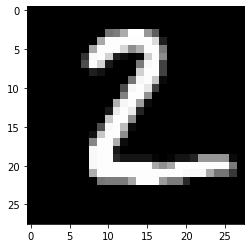

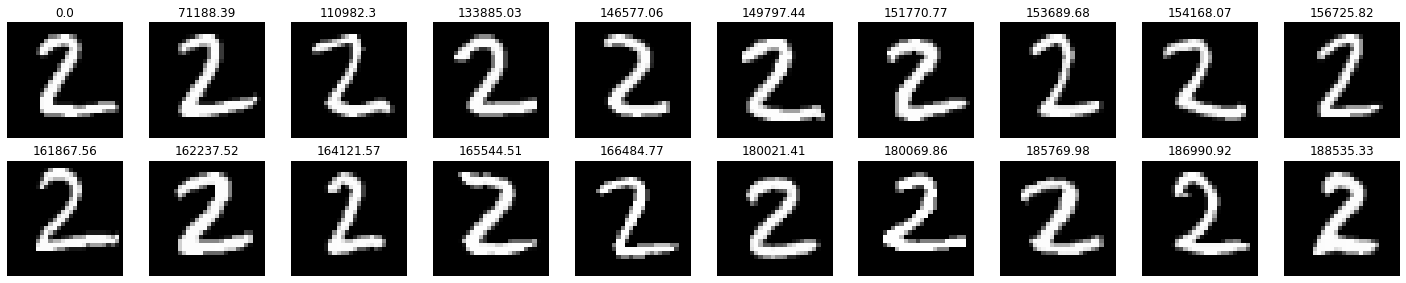

In [14]:
target_idx = 1
plt.imshow(x_test[target_idx], cmap='gray')
plt.show()
target = feature_list[target_idx]

neighbors, neighbors_dist = get_neighbors(feature_list, target, 20)

plt.figure(figsize = (25,25))

for i,neighbor in enumerate(neighbors):
    ax = plt.subplot(10,10,i+1)
    ax.set_title(round(float(neighbors_dist[i]),2))
    plt.imshow(x_test[neighbor], cmap='gray')
    plt.axis('off')
plt.show()

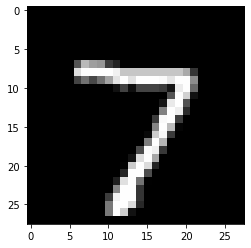

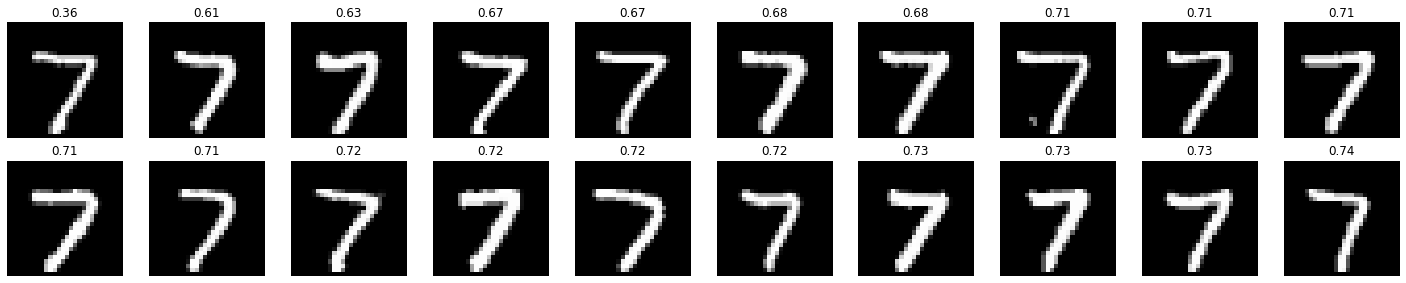

In [11]:
target_idx = 0
plt.imshow(x_test[target_idx], cmap='gray')
plt.show()
target = feature_list[target_idx]

neighbors, neighbors_dist = get_neighbors(feature_list, target, 20)

plt.figure(figsize = (25,25))

for i,neighbor in enumerate(neighbors):
    ax = plt.subplot(10,10,i+1)
    ax.set_title(round(float(neighbors_dist[i]),2))
    plt.imshow(x_test[neighbor], cmap='gray')
    plt.axis('off')
plt.show()

In [70]:
tf.reshape(feature_list[0][1],-1)[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.7213974>